In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import nltk
import transformers
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')

from gensim.models import Word2Vec, word2vec
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
from PIL import Image
import natsort
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import clip

import torch
from transformers import AutoTokenizer, DistilBertModel
import time
import random
import tensorflow as tf
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import mse
from keras import backend as K
from tensorflow.keras.layers import Dropout
TF_ENABLE_ONEDNN_OPTS=0

2023-07-15 01:01:09.559616: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## BASIC UTIL FUNCTION

In [2]:
def export_classification_report(report, mod, exec_time):
    lines = report.split('\n')
    data = lines[2:4] + lines[5:9]
    data = [line.split() for line in data]
    

    acc = float(data[2][1])
    m_prec = float(data[3][2])
    m_recall = float(data[3][3])
    m_f1 = float(data[3][4])
    w_prec = float(data[4][2])
    w_recall = float(data[4][3])
    w_f1 = float(data[4][4])
    
    df = pd.DataFrame({
        'Model': [mod],
        'Accuracy': [acc],
        'M-Precision': [m_prec],
        'M-Recall': [m_recall],
        'M-F1-Score': [m_f1],
        'W-Precision': [w_prec],
        'W-Recall': [w_recall],
        'W-F1-Score': [w_f1],
        'Runtime': [exec_time]
    })
    
    return df

## DATA PREPARATION

In [3]:
# Load the data


#  DistilBERT Embeddings (Text Only); (Train and Test Data Embeddings)

train2 = pd.read_csv('./training1.csv', delimiter='\t')

IDs = []  #set1
images = []
directory = 'TRAINING'   # directory where we have images 
filenames = natsort.natsorted(os.listdir(directory))  

# get the ids from the images, where images are having three channels; omit images if channels != 3
for i, filename in enumerate(filenames):
#     print(i, filename)
    if filename.endswith(".jpg"):
#         ID = int(filename[:-4])
        ID = filename
        pathname = os.path.join(directory, filename)
        im = Image.open(pathname)
        im = im.resize((224, 224))  # Resize the image to (224, 224)
        imnp = np.array(im)
        if len(imnp.shape) != 3:
#             print("This is 1 channel, so we omit it", imnp.shape, filename)
            continue
        IDs.append(ID)
        images.append(imnp)

def get_common_strings(list1, list2):
    return list(set(list1) & set(list2))

# Example usage
list1 = IDs
list2 = list(train2.file_name)  #from the text file where we have text description 
common_strings = get_common_strings(list1, list2)
print('len of common strings', len(common_strings))

sorted_ids = natsort.natsorted(common_strings)

# print(sorted_ids)

# Sort the dataframe with natural ordering of the IDs
train2['prefix_file_name'] = train2['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
sorted_train_df = train2.sort_values(by='prefix_file_name', ascending=True)
sorted_train_df

# Assuming 'df' is your DataFrame and 'common_strings' is the list of strings
# Get the common string values in the column 
filtered_df = sorted_train_df[sorted_train_df['file_name'].isin(sorted_ids)].reset_index(drop=True)

# Print the filtered DataFrame
print('filtered_df shape', filtered_df.shape)

train3 = filtered_df.copy()
# print(train3.shape)

trainx = train3.rename(columns={'Text Transcription': 'text'})
# display(trainx)



### LOAD TEST DATA

test1 = pd.read_csv('Test.csv', delimiter='\t')
test_labels = pd.read_csv('test_labels.txt', 
                          delimiter='\t',
                         header=None)

test_labels.columns = ['file_name', 
                      "misogynous",
                       "shaming",
                       "stereotype",
                       "objectification",
                       "violence"]

merged_test = pd.merge(test1, test_labels, on='file_name', how='inner')


# Sort the dataframe with natural ordering of the IDs
merged_test['prefix_file_name'] = merged_test['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
merged_test1 = merged_test.sort_values(by='prefix_file_name', ascending=True)
merged_test1


# # train = train.rename(columns={'Text Transcription': 'text'})
test2 = merged_test1.rename(columns={'Text Transcription': 'text'})
# test2



# ######################################################
train = trainx[['file_name', 'text', 'misogynous']]
train = train.rename(columns = {'misogynous':'label'})

test = test2[['file_name', 'text', 'misogynous']]
test = test.rename(columns = {'misogynous':'label'})

train['label'] = train['label'].map({0: 'non_misogyn', 1: 'misogyn'})
test['label'] = test['label'].map({0: 'non_misogyn', 1: 'misogyn'})
display(train)
display(test)

len of common strings 9986
filtered_df shape (9986, 8)


,file_name,text,label
0,1.jpg,Milk Milk.zip,non_misogyn
1,2.jpg,-What are you doing? -you told me to satanize ...,non_misogyn
2,3.jpg,imgflip.com ME 1254 NEW BUGS AFTER CHANGES BUG...,non_misogyn
3,4.jpg,Bedroom Kitchen Bathroom Bron memes storage,non_misogyn
4,5.jpg,WAKEUP EARLY FREELANCERS,non_misogyn
...,...,...,...
9981,15002.jpg,WAITING FOR THE END OF THE COVID imgflip.com,non_misogyn
9982,15003.jpg,SMART WOMEN ARE AROUND imgflip.com,non_misogyn
9983,15004.jpg,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,non_misogyn
9984,15005.jpg,COOKING FOR MY WIFE imgflip.com,non_misogyn


,file_name,text,label
436,15001.jpg,G HIS. UNDYING FIDELITY Steve is hot and perfe...,non_misogyn
854,15002.jpg,How limagined myself as a Teacher...... How I ...,non_misogyn
743,15004.jpg,WHERE WILL YOU BE WHEN DIARRHEA STRIKE memecen...,non_misogyn
44,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,non_misogyn
873,15006.jpg,THIS IS HOW YOUR GIRLFRIEND SEES YOUR FEMALE F...,non_misogyn
...,...,...,...
871,17078.jpg,There are multiple reasons to lower your car T...,non_misogyn
683,17079.jpg,MICHELLE OBAMA IS A MAN IGUARANTEE IT makeamem...,misogyn
406,17080.jpg,Looks like the airbags deployed 1234498,non_misogyn
733,17081.jpg,Half woman half horse,non_misogyn


## ALL THREE METHODS RUN FOR FEATURE EXTRACTION

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                        

2023-07-15 01:05:00.132353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 01:05:00.154818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 01:05:00.154952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 01:05:00.155464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10
103/313 [========>.....................] - ETA: 0s - loss: 95.6049 - kl_loss: 1.1041 - mse_loss: 94.5008  

2023-07-15 01:05:00.908936: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 1s 1ms/step - loss: 83.0526 - kl_loss: 0.6604 - mse_loss: 82.3923
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 74.5085 - kl_loss: 0.5433 - mse_loss: 73.9653
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 73.1420 - kl_loss: 0.6462 - mse_loss: 72.4958
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 72.2414 - kl_loss: 0.7330 - mse_loss: 71.5085
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 71.6056 - kl_loss: 0.8081 - mse_loss: 70.7974
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 71.2059 - kl_loss: 0.8426 - mse_loss: 70.3633
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 70.6963 - kl_loss: 0.8945 - mse_loss: 69.8018
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 70.2997 - kl_loss: 0.9283 - mse_loss: 69.3714
Epoch 9/10
313/313 [==============================]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19442	validation_0-logloss:0.68465	validation_1-error:0.24224	validation_1-logloss:0.68580


/home/nitesh/env/dev38/python38/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[1]	validation_0-error:0.19041	validation_0-logloss:0.67648	validation_1-error:0.24474	validation_1-logloss:0.67881
[2]	validation_0-error:0.18991	validation_0-logloss:0.66850	validation_1-error:0.24224	validation_1-logloss:0.67200
[3]	validation_0-error:0.18115	validation_0-logloss:0.66078	validation_1-error:0.23874	validation_1-logloss:0.66569
[4]	validation_0-error:0.18240	validation_0-logloss:0.65339	validation_1-error:0.23674	validation_1-logloss:0.65933
[5]	validation_0-error:0.17864	validation_0-logloss:0.64621	validation_1-error:0.22923	validation_1-logloss:0.65318
[6]	validation_0-error:0.17276	validation_0-logloss:0.63889	validation_1-error:0.22673	validation_1-logloss:0.64709
[7]	validation_0-error:0.16913	validation_0-logloss:0.63209	validation_1-error:0.22873	validation_1-logloss:0.64169
[8]	validation_0-error:0.16913	validation_0-logloss:0.62532	validation_1-error:0.22673	validation_1-logloss:0.63605
[9]	validation_0-error:0.17013	validation_0-logloss:0.61882	validation_1

[72]	validation_0-error:0.12519	validation_0-logloss:0.39857	validation_1-error:0.20520	validation_1-logloss:0.47201
[73]	validation_0-error:0.12481	validation_0-logloss:0.39660	validation_1-error:0.20470	validation_1-logloss:0.47098
[74]	validation_0-error:0.12406	validation_0-logloss:0.39466	validation_1-error:0.20571	validation_1-logloss:0.46984
[75]	validation_0-error:0.12394	validation_0-logloss:0.39282	validation_1-error:0.20470	validation_1-logloss:0.46861
[76]	validation_0-error:0.12293	validation_0-logloss:0.39099	validation_1-error:0.20571	validation_1-logloss:0.46761
[77]	validation_0-error:0.12256	validation_0-logloss:0.38913	validation_1-error:0.20571	validation_1-logloss:0.46653
[78]	validation_0-error:0.12131	validation_0-logloss:0.38736	validation_1-error:0.20520	validation_1-logloss:0.46554
[79]	validation_0-error:0.12043	validation_0-logloss:0.38538	validation_1-error:0.20270	validation_1-logloss:0.46446
[80]	validation_0-error:0.11968	validation_0-logloss:0.38362	val

[142]	validation_0-error:0.08901	validation_0-logloss:0.29981	validation_1-error:0.19269	validation_1-logloss:0.42582
[143]	validation_0-error:0.08838	validation_0-logloss:0.29869	validation_1-error:0.19219	validation_1-logloss:0.42538
[144]	validation_0-error:0.08801	validation_0-logloss:0.29762	validation_1-error:0.19219	validation_1-logloss:0.42497
[145]	validation_0-error:0.08776	validation_0-logloss:0.29647	validation_1-error:0.19119	validation_1-logloss:0.42468
[146]	validation_0-error:0.08663	validation_0-logloss:0.29529	validation_1-error:0.19069	validation_1-logloss:0.42427
[147]	validation_0-error:0.08600	validation_0-logloss:0.29447	validation_1-error:0.19119	validation_1-logloss:0.42391
[148]	validation_0-error:0.08550	validation_0-logloss:0.29338	validation_1-error:0.19069	validation_1-logloss:0.42355
[149]	validation_0-error:0.08500	validation_0-logloss:0.29254	validation_1-error:0.19069	validation_1-logloss:0.42327


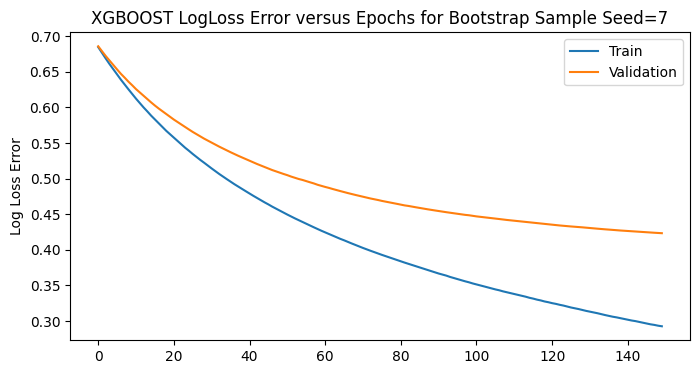

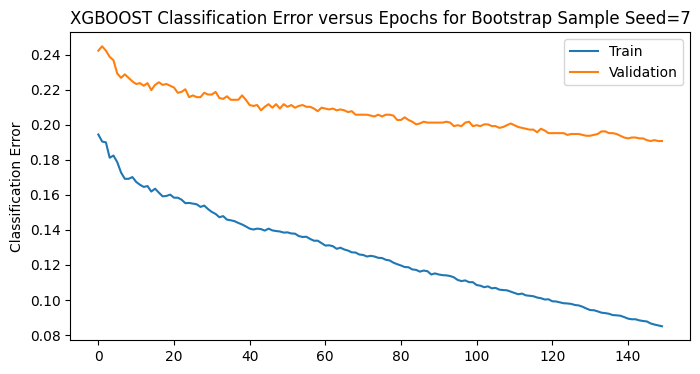

/tmp/ipykernel_51389/11045450.py:529: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.86      0.47      0.61       500
           1       0.64      0.93      0.75       500

    accuracy                           0.70      1000
   macro avg       0.75      0.70      0.68      1000
weighted avg       0.75      0.70      0.68      1000

Execution time: 260.2955901622772 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_5[0][0]']                
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19867	validation_0-logloss:0.68496	validation_1-error:0.25275	validation_1-logloss:0.68607
[1]	validation_0-error:0.18928	validation_0-logloss:0.67716	validation_1-error:0.23123	validation_1-logloss:0.67896
[2]	validation_0-error:0.18703	validation_0-logloss:0.66950	validation_1-error:0.23473	validation_1-logloss:0.67248
[3]	validation_0-error:0.18327	validation_0-logloss:0.66221	validation_1-error:0.23273	validation_1-logloss:0.66613
[4]	validation_0-error:0.18553	validation_0-logloss:0.65509	validation_1-error:0.23373	validation_1-logloss:0.66007
[5]	validation_0-error:0.18140	validation_0-logloss:0.64807	validation_1-error:0.22623	validation_1-logloss:0.65410
[6]	validation_0-error:0.18140	validation_0-logloss:0.64141	validation_1-error:0.22973	validation_1-logloss:0.64849
[7]	validation_0-error:0.18014	validation_0-logloss:0.63489	validation_1-error:0.23473	validation_1-logloss:0.64307
[

[70]	validation_0-error:0.12056	validation_0-logloss:0.41030	validation_1-error:0.19419	validation_1-logloss:0.47669
[71]	validation_0-error:0.11943	validation_0-logloss:0.40834	validation_1-error:0.19520	validation_1-logloss:0.47546
[72]	validation_0-error:0.11880	validation_0-logloss:0.40618	validation_1-error:0.19520	validation_1-logloss:0.47441
[73]	validation_0-error:0.11893	validation_0-logloss:0.40435	validation_1-error:0.19570	validation_1-logloss:0.47323
[74]	validation_0-error:0.11755	validation_0-logloss:0.40225	validation_1-error:0.19620	validation_1-logloss:0.47177
[75]	validation_0-error:0.11743	validation_0-logloss:0.40018	validation_1-error:0.19720	validation_1-logloss:0.47085
[76]	validation_0-error:0.11718	validation_0-logloss:0.39813	validation_1-error:0.19570	validation_1-logloss:0.46959
[77]	validation_0-error:0.11630	validation_0-logloss:0.39637	validation_1-error:0.19620	validation_1-logloss:0.46858
[78]	validation_0-error:0.11567	validation_0-logloss:0.39433	val

[140]	validation_0-error:0.08638	validation_0-logloss:0.30700	validation_1-error:0.18569	validation_1-logloss:0.42534
[141]	validation_0-error:0.08600	validation_0-logloss:0.30584	validation_1-error:0.18518	validation_1-logloss:0.42502
[142]	validation_0-error:0.08550	validation_0-logloss:0.30464	validation_1-error:0.18518	validation_1-logloss:0.42460
[143]	validation_0-error:0.08475	validation_0-logloss:0.30366	validation_1-error:0.18518	validation_1-logloss:0.42411
[144]	validation_0-error:0.08438	validation_0-logloss:0.30253	validation_1-error:0.18518	validation_1-logloss:0.42363
[145]	validation_0-error:0.08363	validation_0-logloss:0.30142	validation_1-error:0.18569	validation_1-logloss:0.42319
[146]	validation_0-error:0.08363	validation_0-logloss:0.30064	validation_1-error:0.18518	validation_1-logloss:0.42287
[147]	validation_0-error:0.08338	validation_0-logloss:0.29972	validation_1-error:0.18518	validation_1-logloss:0.42241
[148]	validation_0-error:0.08275	validation_0-logloss:0.

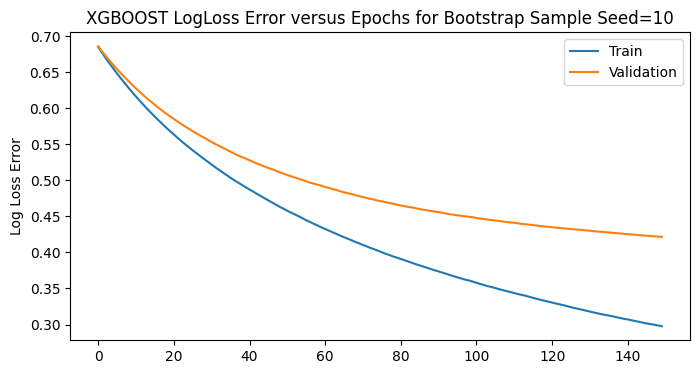

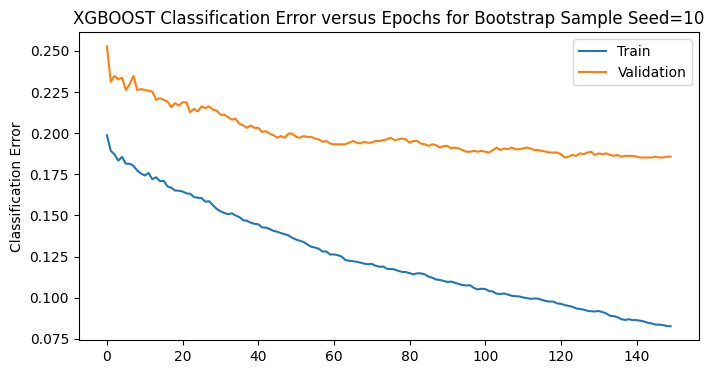

/tmp/ipykernel_51389/11045450.py:529: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.85      0.50      0.63       500
           1       0.64      0.91      0.76       500

    accuracy                           0.70      1000
   macro avg       0.75      0.71      0.69      1000
weighted avg       0.75      0.70      0.69      1000

Execution time: 282.6770119667053 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['dense_10[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.17802	validation_0-logloss:0.68407	validation_1-error:0.24074	validation_1-logloss:0.68551
[1]	validation_0-error:0.17301	validation_0-logloss:0.67531	validation_1-error:0.24575	validation_1-logloss:0.67832
[2]	validation_0-error:0.16375	validation_0-logloss:0.66688	validation_1-error:0.23674	validation_1-logloss:0.67136
[3]	validation_0-error:0.16450	validation_0-logloss:0.65871	validation_1-error:0.23574	validation_1-logloss:0.66463
[4]	validation_0-error:0.16212	validation_0-logloss:0.65088	validation_1-error:0.23624	validation_1-logloss:0.65832
[5]	validation_0-error:0.15924	validation_0-logloss:0.64329	validation_1-error:0.23373	validation_1-logloss:0.65216
[6]	validation_0-error:0.15523	validation_0-logloss:0.63592	validation_1-error:0.23423	validation_1-logloss:0.64607
[7]	validation_0-error:0.15623	validation_0-logloss:0.62877	validation_1-error:0.22823	validation_1-logloss:0.64019
[

[70]	validation_0-error:0.12394	validation_0-logloss:0.39704	validation_1-error:0.20320	validation_1-logloss:0.47367
[71]	validation_0-error:0.12331	validation_0-logloss:0.39498	validation_1-error:0.20320	validation_1-logloss:0.47256
[72]	validation_0-error:0.12156	validation_0-logloss:0.39298	validation_1-error:0.20270	validation_1-logloss:0.47128
[73]	validation_0-error:0.12118	validation_0-logloss:0.39098	validation_1-error:0.20370	validation_1-logloss:0.47038
[74]	validation_0-error:0.12068	validation_0-logloss:0.38899	validation_1-error:0.20370	validation_1-logloss:0.46948
[75]	validation_0-error:0.12068	validation_0-logloss:0.38722	validation_1-error:0.20270	validation_1-logloss:0.46821
[76]	validation_0-error:0.11968	validation_0-logloss:0.38530	validation_1-error:0.20320	validation_1-logloss:0.46729
[77]	validation_0-error:0.11980	validation_0-logloss:0.38359	validation_1-error:0.20270	validation_1-logloss:0.46615
[78]	validation_0-error:0.11930	validation_0-logloss:0.38183	val

[140]	validation_0-error:0.09026	validation_0-logloss:0.29650	validation_1-error:0.19570	validation_1-logloss:0.42693
[141]	validation_0-error:0.08963	validation_0-logloss:0.29554	validation_1-error:0.19620	validation_1-logloss:0.42648
[142]	validation_0-error:0.08938	validation_0-logloss:0.29442	validation_1-error:0.19720	validation_1-logloss:0.42613
[143]	validation_0-error:0.08913	validation_0-logloss:0.29338	validation_1-error:0.19570	validation_1-logloss:0.42569
[144]	validation_0-error:0.08913	validation_0-logloss:0.29222	validation_1-error:0.19570	validation_1-logloss:0.42529
[145]	validation_0-error:0.08826	validation_0-logloss:0.29106	validation_1-error:0.19570	validation_1-logloss:0.42500
[146]	validation_0-error:0.08851	validation_0-logloss:0.29013	validation_1-error:0.19520	validation_1-logloss:0.42467
[147]	validation_0-error:0.08851	validation_0-logloss:0.28929	validation_1-error:0.19570	validation_1-logloss:0.42434
[148]	validation_0-error:0.08813	validation_0-logloss:0.

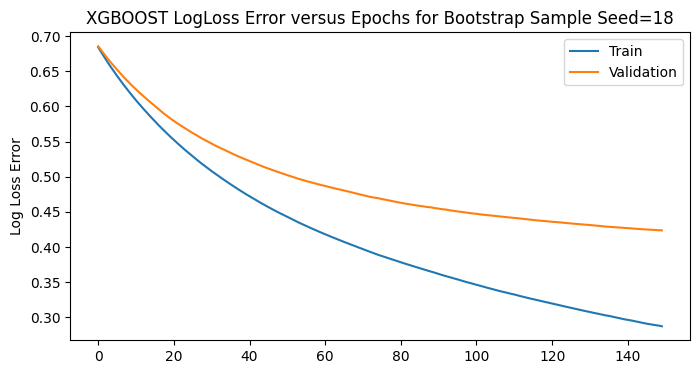

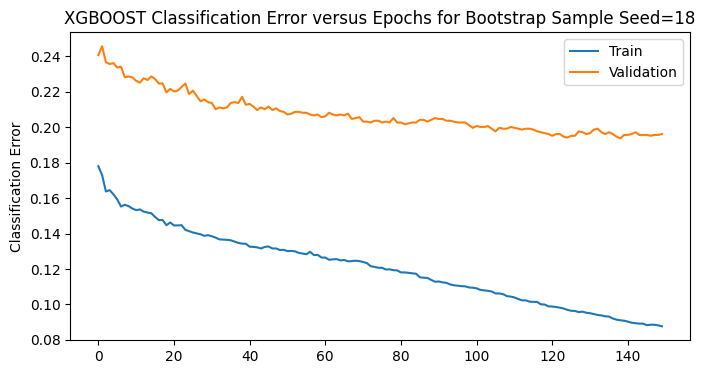

/tmp/ipykernel_51389/11045450.py:529: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.88      0.51      0.65       500
           1       0.66      0.93      0.77       500

    accuracy                           0.72      1000
   macro avg       0.77      0.72      0.71      1000
weighted avg       0.77      0.72      0.71      1000

Execution time: 279.2235906124115 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_6 (Dropout)            (None, 128)          0           ['dense_15[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19980	validation_0-logloss:0.68500	validation_1-error:0.26927	validation_1-logloss:0.68673
[1]	validation_0-error:0.17414	validation_0-logloss:0.67714	validation_1-error:0.25075	validation_1-logloss:0.68033
[2]	validation_0-error:0.17927	validation_0-logloss:0.66957	validation_1-error:0.25325	validation_1-logloss:0.67447
[3]	validation_0-error:0.17351	validation_0-logloss:0.66223	validation_1-error:0.25075	validation_1-logloss:0.66861
[4]	validation_0-error:0.17351	validation_0-logloss:0.65517	validation_1-error:0.24625	validation_1-logloss:0.66311
[5]	validation_0-error:0.17188	validation_0-logloss:0.64830	validation_1-error:0.24274	validation_1-logloss:0.65775
[6]	validation_0-error:0.17476	validation_0-logloss:0.64170	validation_1-error:0.24775	validation_1-logloss:0.65253
[7]	validation_0-error:0.16925	validation_0-logloss:0.63511	validation_1-error:0.24524	validation_1-logloss:0.64746
[

[70]	validation_0-error:0.12093	validation_0-logloss:0.41294	validation_1-error:0.20571	validation_1-logloss:0.48600
[71]	validation_0-error:0.11968	validation_0-logloss:0.41104	validation_1-error:0.20370	validation_1-logloss:0.48474
[72]	validation_0-error:0.11918	validation_0-logloss:0.40900	validation_1-error:0.20571	validation_1-logloss:0.48361
[73]	validation_0-error:0.11843	validation_0-logloss:0.40725	validation_1-error:0.20320	validation_1-logloss:0.48246
[74]	validation_0-error:0.11805	validation_0-logloss:0.40525	validation_1-error:0.20520	validation_1-logloss:0.48135
[75]	validation_0-error:0.11705	validation_0-logloss:0.40330	validation_1-error:0.20220	validation_1-logloss:0.48008
[76]	validation_0-error:0.11693	validation_0-logloss:0.40126	validation_1-error:0.20170	validation_1-logloss:0.47885
[77]	validation_0-error:0.11630	validation_0-logloss:0.39937	validation_1-error:0.20170	validation_1-logloss:0.47792
[78]	validation_0-error:0.11617	validation_0-logloss:0.39767	val

[140]	validation_0-error:0.09126	validation_0-logloss:0.31442	validation_1-error:0.19069	validation_1-logloss:0.43156
[141]	validation_0-error:0.08989	validation_0-logloss:0.31321	validation_1-error:0.19119	validation_1-logloss:0.43091
[142]	validation_0-error:0.08951	validation_0-logloss:0.31233	validation_1-error:0.19219	validation_1-logloss:0.43040
[143]	validation_0-error:0.08951	validation_0-logloss:0.31144	validation_1-error:0.19219	validation_1-logloss:0.42994
[144]	validation_0-error:0.08913	validation_0-logloss:0.31018	validation_1-error:0.19219	validation_1-logloss:0.42939
[145]	validation_0-error:0.08863	validation_0-logloss:0.30930	validation_1-error:0.19169	validation_1-logloss:0.42897
[146]	validation_0-error:0.08826	validation_0-logloss:0.30845	validation_1-error:0.19069	validation_1-logloss:0.42854
[147]	validation_0-error:0.08763	validation_0-logloss:0.30757	validation_1-error:0.19069	validation_1-logloss:0.42819
[148]	validation_0-error:0.08713	validation_0-logloss:0.

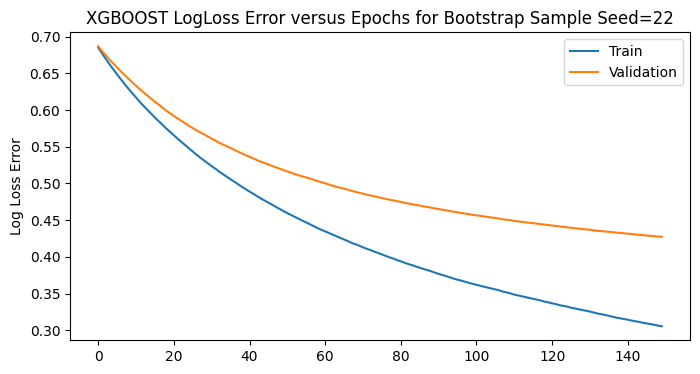

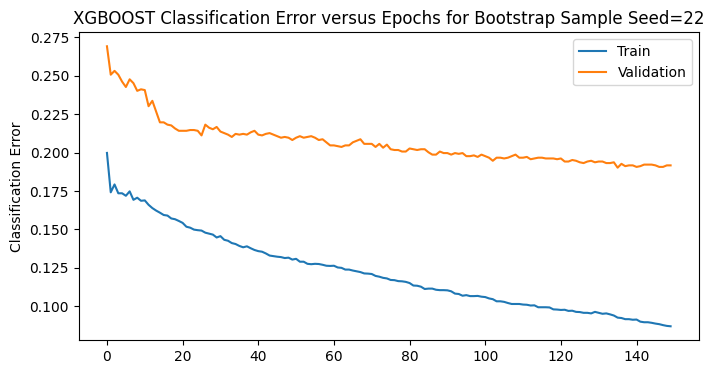

/tmp/ipykernel_51389/11045450.py:529: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.87      0.50      0.63       500
           1       0.65      0.92      0.76       500

    accuracy                           0.71      1000
   macro avg       0.76      0.71      0.70      1000
weighted avg       0.76      0.71      0.70      1000

Execution time: 290.4093441963196 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 128)          0           ['dense_20[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.20794	validation_0-logloss:0.68502	validation_1-error:0.27177	validation_1-logloss:0.68637
[1]	validation_0-error:0.20356	validation_0-logloss:0.67726	validation_1-error:0.26577	validation_1-logloss:0.67987
[2]	validation_0-error:0.20218	validation_0-logloss:0.66969	validation_1-error:0.26376	validation_1-logloss:0.67363
[3]	validation_0-error:0.18478	validation_0-logloss:0.66208	validation_1-error:0.25225	validation_1-logloss:0.66754
[4]	validation_0-error:0.18365	validation_0-logloss:0.65496	validation_1-error:0.24825	validation_1-logloss:0.66170
[5]	validation_0-error:0.17051	validation_0-logloss:0.64782	validation_1-error:0.23674	validation_1-logloss:0.65564
[6]	validation_0-error:0.16913	validation_0-logloss:0.64124	validation_1-error:0.23724	validation_1-logloss:0.65033
[7]	validation_0-error:0.16925	validation_0-logloss:0.63443	validation_1-error:0.23674	validation_1-logloss:0.64485
[

[70]	validation_0-error:0.11229	validation_0-logloss:0.40520	validation_1-error:0.20470	validation_1-logloss:0.47821
[71]	validation_0-error:0.11142	validation_0-logloss:0.40312	validation_1-error:0.20420	validation_1-logloss:0.47697
[72]	validation_0-error:0.11154	validation_0-logloss:0.40127	validation_1-error:0.20420	validation_1-logloss:0.47572
[73]	validation_0-error:0.11067	validation_0-logloss:0.39929	validation_1-error:0.20270	validation_1-logloss:0.47442
[74]	validation_0-error:0.10979	validation_0-logloss:0.39753	validation_1-error:0.20320	validation_1-logloss:0.47326
[75]	validation_0-error:0.10991	validation_0-logloss:0.39558	validation_1-error:0.20270	validation_1-logloss:0.47198
[76]	validation_0-error:0.10966	validation_0-logloss:0.39392	validation_1-error:0.20270	validation_1-logloss:0.47086
[77]	validation_0-error:0.10904	validation_0-logloss:0.39201	validation_1-error:0.20120	validation_1-logloss:0.46972
[78]	validation_0-error:0.10841	validation_0-logloss:0.39011	val

[140]	validation_0-error:0.08450	validation_0-logloss:0.30796	validation_1-error:0.19570	validation_1-logloss:0.42540
[141]	validation_0-error:0.08475	validation_0-logloss:0.30698	validation_1-error:0.19670	validation_1-logloss:0.42507
[142]	validation_0-error:0.08438	validation_0-logloss:0.30571	validation_1-error:0.19620	validation_1-logloss:0.42472
[143]	validation_0-error:0.08363	validation_0-logloss:0.30452	validation_1-error:0.19520	validation_1-logloss:0.42417
[144]	validation_0-error:0.08363	validation_0-logloss:0.30354	validation_1-error:0.19670	validation_1-logloss:0.42386
[145]	validation_0-error:0.08300	validation_0-logloss:0.30255	validation_1-error:0.19570	validation_1-logloss:0.42347
[146]	validation_0-error:0.08300	validation_0-logloss:0.30175	validation_1-error:0.19520	validation_1-logloss:0.42301
[147]	validation_0-error:0.08250	validation_0-logloss:0.30079	validation_1-error:0.19570	validation_1-logloss:0.42268
[148]	validation_0-error:0.08225	validation_0-logloss:0.

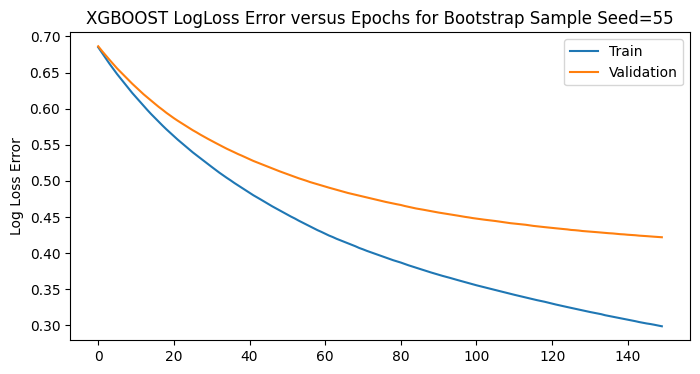

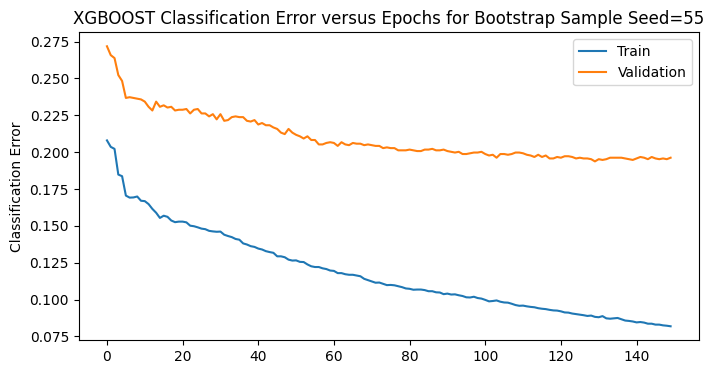

/tmp/ipykernel_51389/11045450.py:529: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.86      0.52      0.65       500
           1       0.66      0.92      0.77       500

    accuracy                           0.72      1000
   macro avg       0.76      0.72      0.71      1000
weighted avg       0.76      0.72      0.71      1000

Execution time: 276.4654772281647 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_10 (Dropout)           (None, 128)          0           ['dense_25[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19354	validation_0-logloss:0.68424	validation_1-error:0.23273	validation_1-logloss:0.68554
[1]	validation_0-error:0.18841	validation_0-logloss:0.67569	validation_1-error:0.22973	validation_1-logloss:0.67824
[2]	validation_0-error:0.17739	validation_0-logloss:0.66711	validation_1-error:0.22372	validation_1-logloss:0.67132
[3]	validation_0-error:0.18002	validation_0-logloss:0.65912	validation_1-error:0.22372	validation_1-logloss:0.66453
[4]	validation_0-error:0.17163	validation_0-logloss:0.65118	validation_1-error:0.22272	validation_1-logloss:0.65797
[5]	validation_0-error:0.17326	validation_0-logloss:0.64372	validation_1-error:0.22172	validation_1-logloss:0.65185
[6]	validation_0-error:0.16975	validation_0-logloss:0.63632	validation_1-error:0.22122	validation_1-logloss:0.64558
[7]	validation_0-error:0.16863	validation_0-logloss:0.62925	validation_1-error:0.22072	validation_1-logloss:0.63968
[

[70]	validation_0-error:0.12657	validation_0-logloss:0.39552	validation_1-error:0.20270	validation_1-logloss:0.46778
[71]	validation_0-error:0.12744	validation_0-logloss:0.39349	validation_1-error:0.20120	validation_1-logloss:0.46662
[72]	validation_0-error:0.12694	validation_0-logloss:0.39143	validation_1-error:0.20120	validation_1-logloss:0.46549
[73]	validation_0-error:0.12556	validation_0-logloss:0.38925	validation_1-error:0.20170	validation_1-logloss:0.46444
[74]	validation_0-error:0.12569	validation_0-logloss:0.38733	validation_1-error:0.20120	validation_1-logloss:0.46331
[75]	validation_0-error:0.12606	validation_0-logloss:0.38544	validation_1-error:0.20070	validation_1-logloss:0.46199
[76]	validation_0-error:0.12494	validation_0-logloss:0.38335	validation_1-error:0.20020	validation_1-logloss:0.46091
[77]	validation_0-error:0.12481	validation_0-logloss:0.38159	validation_1-error:0.19970	validation_1-logloss:0.45981
[78]	validation_0-error:0.12519	validation_0-logloss:0.37966	val

[140]	validation_0-error:0.09352	validation_0-logloss:0.29619	validation_1-error:0.19219	validation_1-logloss:0.42279
[141]	validation_0-error:0.09289	validation_0-logloss:0.29539	validation_1-error:0.19219	validation_1-logloss:0.42244
[142]	validation_0-error:0.09226	validation_0-logloss:0.29424	validation_1-error:0.19269	validation_1-logloss:0.42231
[143]	validation_0-error:0.09189	validation_0-logloss:0.29320	validation_1-error:0.19269	validation_1-logloss:0.42194
[144]	validation_0-error:0.09151	validation_0-logloss:0.29204	validation_1-error:0.19219	validation_1-logloss:0.42174
[145]	validation_0-error:0.09076	validation_0-logloss:0.29122	validation_1-error:0.19219	validation_1-logloss:0.42146
[146]	validation_0-error:0.08989	validation_0-logloss:0.29018	validation_1-error:0.19219	validation_1-logloss:0.42109
[147]	validation_0-error:0.08951	validation_0-logloss:0.28922	validation_1-error:0.19169	validation_1-logloss:0.42074
[148]	validation_0-error:0.08951	validation_0-logloss:0.

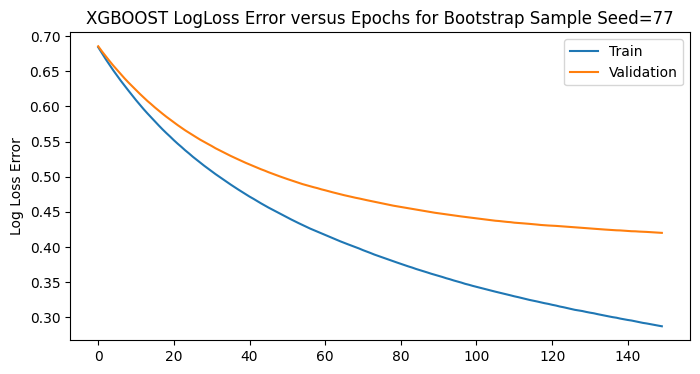

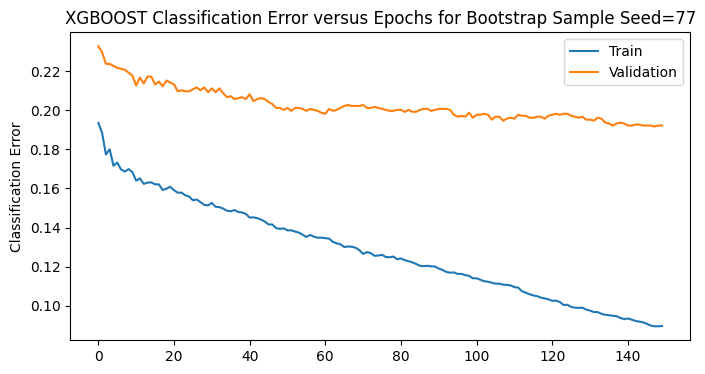

              precision    recall  f1-score   support

           0       0.86      0.48      0.62       500
           1       0.64      0.92      0.76       500

    accuracy                           0.70      1000
   macro avg       0.75      0.70      0.69      1000
weighted avg       0.75      0.70      0.69      1000

Execution time: 282.48558473587036 seconds


/tmp/ipykernel_51389/11045450.py:529: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


In [4]:
### TRAINING

df_BLPCLPXGB = pd.DataFrame(columns=['Model', 'Accuracy', 
                       'M-Precision', 'M-Recall', 
                       'M-F1-Score', 'W-Precision',
                       'W-Recall', 'W-F1-Score', 'Runtime'])


mse_val1 = []
KL_LOSS1 = []

# Store results in DataFrame
xgboost_clsfn_errrep  = pd.DataFrame(columns=["Bootstrap_Sample_Seed", "Train_LogLoss",
                                              "Validation_LogLoss", "Train_Error",
                                              "Validation_Error"])



for KK in list([7,10,18,22,55,77]):
    
    start_time = time.time()

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)


    device = "cpu"

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    model.to(device)
    projection_layer = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer.to(device)

    train_encodings = tokenizer(
        train["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings = tokenizer(
        test["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )


    with torch.no_grad():
        train_outputs = model(**train_encodings.to(device))
        train_embeddings = train_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings = projection_layer(train_embeddings)  # Project embeddings to size 65

        test_outputs = model(**test_encodings.to(device))
        test_embeddings = test_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings = projection_layer(test_embeddings)  # Project embeddings to size 65

    train_embeddings = train_embeddings.cpu().numpy()
    test_embeddings = test_embeddings.cpu().numpy()

    print("train embeddings shape:", train_embeddings.shape)
    print("test embeddings shape:", test_embeddings.shape)





    # CLIP Image Embeddings (Training Image Embeddings)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


    # model_16

    # Define the directory containing the images
    IDs = []  #set1
    images = []
    image_dir = "./TRAINING"
    # # Load the data
    train2 = pd.read_csv('./training1.csv', delimiter='\t')

    # Get a list of image filenames in the directory
    filenames = natsort.natsorted(os.listdir(image_dir))
    # len(image_filenames)

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(filenames):
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            ID = filename
            pathname = os.path.join(image_dir, filename)
            im = Image.open(pathname)
    #         print(im.size)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            imnp = np.array(im)
            if len(imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue
            IDs.append(ID)
            images.append(imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    list1 = IDs
    list2 = list(train2.file_name)  #from the text file where we have text description 
    common_strings = get_common_strings(list1, list2)
    print('len of common strings', len(common_strings))

    image_filenames = natsort.natsorted(common_strings)
    # display(image_filenames)

    import pandas as pd

    train_labelset = train2[['file_name', 'misogynous']]
    IDs_df = pd.DataFrame({'file_name': image_filenames})
    joined_df = IDs_df.merge(train_labelset, on='file_name', how='left')
    misogynous_labels = joined_df['misogynous'].tolist()


    #######################################################################


    # Create an empty list to store the image features
    all_image_features_16 = []


    model_16, preprocess_16 = clip.load('ViT-B/16', device=device)

    # Process each image and extract features
    for filename in image_filenames:
        image_path = os.path.join(image_dir, filename)

        # Preprocess the image
        image_16 = preprocess_16(Image.open(image_path)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features_16 = model_16.encode_image(image_16)

        # Append the image features to the list
        all_image_features_16.append(image_features_16)

    # Concatenate the image features into a single tensor
    all_image_features_16 = torch.cat(all_image_features_16, dim=0)
    print(all_image_features_16.shape)
    # torch.Size([9986, 512])



    ## REDUCE 512 EMBEDDING SIZE TO 64 EMBEDDING SIZE #####
    #######################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    embedding_size = 64
    all_image_features_16_cpu = all_image_features_16.cpu()
    all_image_features_16_numpy = all_image_features_16_cpu.numpy()



    ## using the below Sampling class from WK08 lab tutorials. 
    class Sampling(layers.Layer):


        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
            Sampling from the distribution of z_mu and z_var helps in 
            generating new point in latent space which we can pass to the decoder network 
            to reconstruct the data samples similar to original input
        """
        def call(self, inputs):

            #the encoder network produces a mean and a variance for each dimension of the latent space.
            z_mean, z_log_var = inputs

            # epsilon is not a weight (ie is not learned) and is not calculated based on 
            # the output of the previous layer.
            # epsilon is just a constant Tensor (a new one, each time we call this layer).


            epsilon = K.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
            return z_mean + K.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)


    # for the encoder part, now the original dimension would be the pretrained model output flattened features
    # dimension
    original_dim = all_image_features_16_numpy.shape[1] 
    intermediate_dim = 128  
    intermediate_dim_1 = 64

    latent_dim = embedding_size  # i.e. 18, we set latent dimension to be of embedding size i.e. 18.

    # Define Input to the encoder 
    #Encoder Model Structure
    original_inputs = layers.Input(shape=(original_dim,), name="encoder_input")
    x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim_1, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))   #updated
    encoder = models.Model(inputs=original_inputs, outputs=z, name="encoder") 
    # encoder = models.Model(inputs=original_inputs, outputs=[z_mean, z_log_var], name="encoder")


    #decoder model
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(intermediate_dim_1, activation="relu")(latent_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim, activation="relu")(x)
    outputs = layers.Dense(original_dim, activation="sigmoid")(x)
    decoder = models.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

    # z = Sampling()((z_mean, z_log_var))
    outputs = decoder(z)
    vae = models.Model(inputs=original_inputs, outputs=outputs, name="vae")
    vae.summary()

    #get the reconstruction loss
    reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
    reconstruction_loss = original_dim * K.mean(reconstruction_loss)

    # regularization KL divergence term encourages the learned latent space to be a smooth manifold.
    kl_loss = -0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(kl_loss)
    vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
    vae.add_loss(reconstruction_loss)
    vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

    # set Adam optimizer with learning ate 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    #Compile the model 
    vae.compile(optimizer)


    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    vaemod = vae.fit(all_image_features_16_numpy, all_image_features_16_numpy, epochs=10)


    ## KL LOSS

    KL_LOSS =  vaemod.history['kl_loss']

    KL_LOSS1.append(KL_LOSS)

    mse_val =  vaemod.history['mse_loss']
    print(mse_val)

    mse_val1.append(mse_val)


    latent_emb = encoder.predict(all_image_features_16_numpy)  
    # z_mean, z_log_var = encoder.predict(all_image_features_16_numpy)
    # latent_emb = Sampling()((z_mean, z_log_var))
    print(latent_emb.shape) 

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')





    # CLIP Image Embeddings (Test Image Embeddings)

    # TEST DATA IMAGES LOADING


    TEST_IDs = []  #set1
    TEST_images = []
    TEST_directory = './TEST'   # directory where we have images 
    test_filenames = natsort.natsorted(os.listdir(TEST_directory))  

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(test_filenames):
    #     print(i, filename)
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            TEST_ID = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_imnp = np.array(im)
            if len(TEST_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_imnp.shape, filename)
                continue
            TEST_IDs.append(TEST_ID)
            TEST_images.append(TEST_imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    TEST_list1 = TEST_IDs
    TEST_list2 = list(test2.file_name)  #from the text file where we have text description 
    TEST_common_strings = get_common_strings(TEST_list1, TEST_list2)
    print('len of common strings', len(TEST_common_strings))

    TEST_sorted_ids = natsort.natsorted(TEST_common_strings)
    # len(TEST_sorted_ids)


    TEST_IDs1 = []
    TEST_images1 = [] 
    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(TEST_sorted_ids):
    #     print(i, filename)
        if filename.endswith(".jpg"):
            TEST_ID_0 = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_1_imnp = np.array(im)
            if len(TEST_1_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_1_imnp.shape, filename)
                continue
    #         print('Filename', TEST_ID_0)
            TEST_IDs1.append(TEST_ID_0)
            TEST_images1.append(TEST_1_imnp)


    len(TEST_images1), len(TEST_IDs1)


    #### TEST EMBEDDINGS #####
    clip_test_embeddings = []

    for image in TEST_images1:
        # Preprocess the image
        image_tensor = preprocess_16(Image.fromarray(image)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features = model_16.encode_image(image_tensor)

        # Append the image features to the list
        clip_test_embeddings.append(image_features)

    clip_test_embeddings = torch.cat(clip_test_embeddings, dim=0)

    # Move the test embeddings tensor to the CPU
    clip_test_embeddings = clip_test_embeddings.cpu()

    # Convert the test embeddings tensor to a NumPy array
    clip_test_embeddings_np = clip_test_embeddings.numpy()

    # Use the existing encoder to reduce the dimensions of the test embeddings
    reduced_test_embeddings  = encoder.predict(clip_test_embeddings_np)
    # z_mean_clipmod, z_log_var_clipmod = encoder.predict(clip_test_embeddings_np)
    # reduced_test_embeddings = Sampling()((z_mean_clipmod, z_log_var_clipmod))

    print('Image Test Embeddings Dimension', reduced_test_embeddings.shape)



    if os.getcwd() != "/home/nitesh/Documents/MY_THESIS/MAMI/BLIP":
        %cd BLIP
    print(os.getcwd())

    # Load the training captions data and test captions data files. 
    train_capn = pd.read_csv('train_BLIP_captions.csv')

    test_capn = pd.read_csv('test_BLIP_captions.csv')



    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP

    from transformers import DistilBertTokenizer, DistilBertModel
    tokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model1 = DistilBertModel.from_pretrained("distilbert-base-uncased")


    device = "cpu"
    model1.to(device)
    projection_layer1 = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer1.to(device)

    train_encodings1 = tokenizer1(
        train_capn["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings1 = tokenizer1(
        test_capn["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        train_outputs1 = model1(**train_encodings1.to(device))
        train_embeddings1 = train_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings1 = projection_layer1(train_embeddings1)  # Project embeddings to size 65

        test_outputs1 = model1(**test_encodings1.to(device))
        test_embeddings1 = test_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings1 = projection_layer1(test_embeddings1)  # Project embeddings to size 65


    # Concatenate the text and image embeddings
    fusion_embeddings_train = np.concatenate((train_embeddings, latent_emb, train_embeddings1), axis=1)
    print('Fusion Embeddings Train', fusion_embeddings_train.shape)


    # Concatenate the text and image embeddings
    fusion_embeddings_test = np.concatenate((test_embeddings, reduced_test_embeddings, test_embeddings1), axis=1)
    print('Fusion Embeddings Test', fusion_embeddings_test.shape)


    import pickle
    # Save the embeddings as a pickle object
    pickle_path_train = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/fusion_embeddings_train_{KK}.pkl"
    with open(pickle_path_train, 'wb') as f:
        pickle.dump(fusion_embeddings_train, f)

    # Save the embeddings as a pickle object
    pickle_path_test = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/fusion_embeddings_test_{KK}.pkl"
    with open(pickle_path_test, 'wb') as f:
        pickle.dump(fusion_embeddings_test, f)


    from sklearn.model_selection import train_test_split
    import xgboost as xgb 
    train_lbls = train.label.map({'non_misogyn': 0, 'misogyn': 1})

    X_train, X_test, y_train, y_test = train_test_split(fusion_embeddings_train, train_lbls, 
                                                        test_size=0.20, random_state=7)

    # Initialize the XGBoost Classifier
    xgb_classifier = xgb.XGBClassifier(n_estimators=150, learning_rate=0.02)

    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_classifier.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

    from matplotlib import pyplot
    import matplotlib.pyplot as plt

    results = xgb_classifier.evals_result()
    epochs = len(results["validation_0"]["error"])
    x_axis = range(0, epochs)


    # plot log loss
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
    ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
    ax.legend()
    pyplot.ylabel("Log Loss Error")
    pyplot.title(f'XGBOOST LogLoss Error versus Epochs for Bootstrap Sample Seed={KK}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'XGB00ST_LogLoss_Error_{KK}.png')
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["error"], label="Train")
    ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
    ax.legend()
    pyplot.ylabel("Classification Error")
    pyplot.title(f'XGBOOST Classification Error versus Epochs for Bootstrap Sample Seed={KK}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'XGB00ST_Classification_Error_{KK}.png')
    pyplot.show()


    row_data = {
        "Bootstrap_Sample_Seed": KK,
        "Train_LogLoss": results["validation_0"]["logloss"],
        "Validation_LogLoss": results["validation_1"]["logloss"],
        "Train_Error": results["validation_0"]["error"],
        "Validation_Error": results["validation_1"]["error"]
    }
    xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


    # Make predictions on the test set
    from sklearn.metrics import classification_report 

    y_pred = xgb_classifier.predict(fusion_embeddings_test)
    # test_lbls = test.label

    test_lbls = test.label.map({'non_misogyn': 0, 'misogyn': 1})
    print(classification_report(test_lbls, y_pred))
    #     print(classification_report(test["label"].tolist(), y_pred))

    report_clip_blip_xgboost = classification_report(test_lbls, y_pred, digits=3)
    #     report_clip_blip_xgboost = classification_report(test["label"].tolist(), y_pred, digits=3)
    #     print(classification_report(test["label"].tolist(), y_pred))


    end_time = time.time()
    execution_time1 = end_time - start_time

    print(f"Execution time: {execution_time1} seconds")

    modname = 'DistilBERT_ViT_VAE_BLIP_XGBOOST'
    df1 = export_classification_report(report_clip_blip_xgboost, modname, execution_time1)
    df_BLPCLPXGB = pd.concat([df_BLPCLPXGB, df1])
    
    os.chdir("/home/nitesh/Documents/MY_THESIS/MAMI")

    del start_time, tokenizer, model, projection_layer
    del train_encodings, test_encodings, train_outputs, test_outputs
    del train_embeddings, test_embeddings
    del IDs, images, image_dir, train2, filenames, common_strings, image_filenames
    del train_labelset, IDs_df, joined_df, misogynous_labels
    del all_image_features_16, model_16, preprocess_16
    del all_image_features_16_cpu, all_image_features_16_numpy
    del Sampling, original_dim, intermediate_dim, intermediate_dim_1, latent_dim
    del original_inputs, x, z_mean, z_log_var, z, encoder
    del latent_inputs, outputs, decoder, vae, optimizer, reconstruction_loss, kl_loss
    del latent_emb, TEST_IDs, TEST_images, TEST_directory, test_filenames, TEST_common_strings
    del TEST_sorted_ids, TEST_IDs1, TEST_images1, clip_test_embeddings, clip_test_embeddings_np
    del reduced_test_embeddings, train_capn, test_capn

    # display(xgboost_clsfn_errrep)

In [5]:
# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/4_xgboost_clsfn_errrep.csv'
xgboost_clsfn_errrep.to_csv(csv_file, index=False)

## VAE TRAINING LOSS VS EPOCH PLOT [SAVE PLOT]

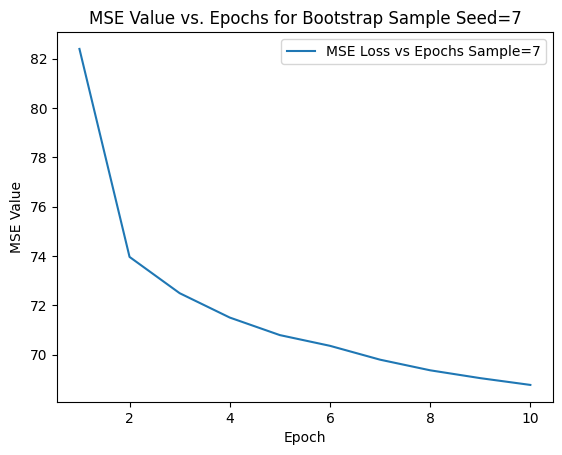

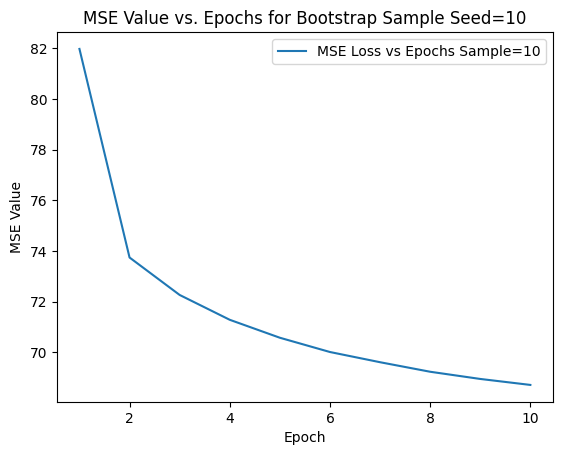

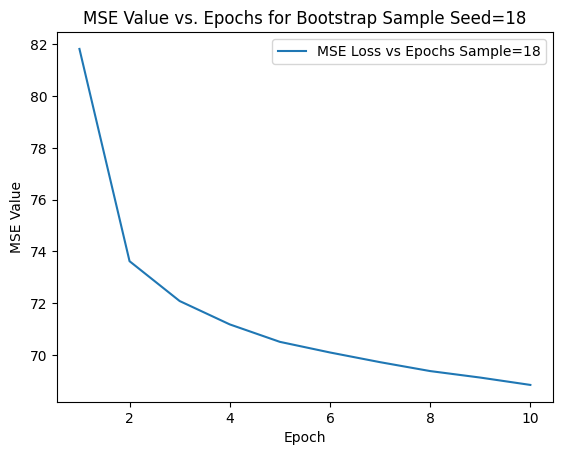

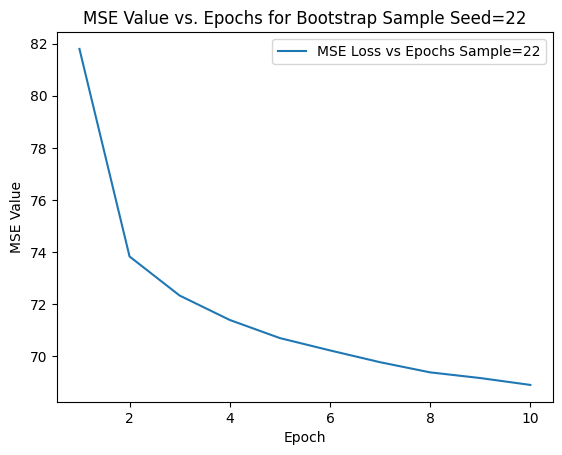

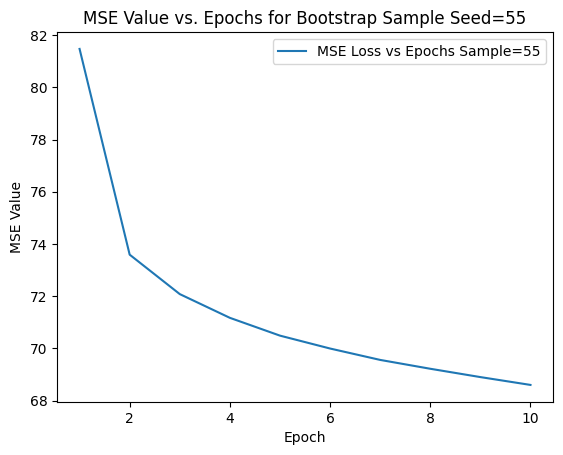

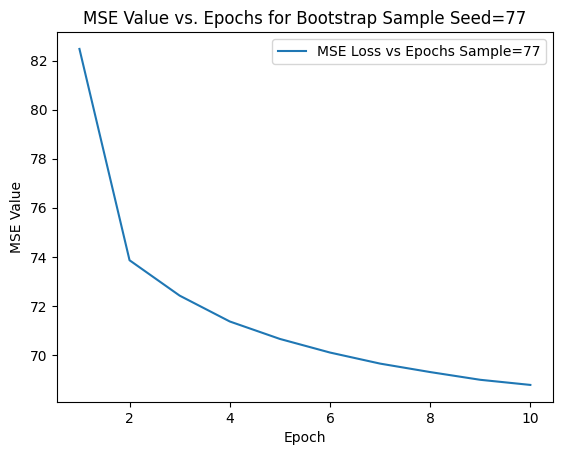

In [7]:
num_lists = len(mse_val1)  # Number of lists
epochs_vae = range(1, 11)  # Epochs (assuming 10 epochs)


# Plot each list in mse_val1
for i, j in zip(range(num_lists), list([7,10,18,22,55,77])):         
    plt.plot(epochs_vae, mse_val1[i], label=f'MSE Loss vs Epochs Sample={j}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Value')
    plt.title(f'MSE Value vs. Epochs for Bootstrap Sample Seed={j}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'4_VAE_TrainingLoss_Epoch_Plot_{j}.png')
    plt.legend()
    plt.show()
    plt.close()  # Close the connection 

# # Save the plots in the local directory
# for i in range(num_lists):
#     plt.savefig(f'plot_{i}.png')
#     plt.close()  # Cl

## SAVE MSE ERROR RESULTS CORRESPONDING TO VAE TRAINING 

In [8]:
# Write mse_val1 to CSV file
df = pd.DataFrame(mse_val1)

# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/4_VAE_training_loss_epochs.csv'

df.to_csv(csv_file, index=False)

## SAVE THE CLASSIFICATION REPORT ERROR TO LOCAL 

In [10]:
df_BLPCLPXGB.to_excel('4_1_classification_report_DistilBERT_ViT_VAE_BLIP_XGBOOST.xlsx', index=False)

# References

https://xgboost.readthedocs.io/en/stable/parameter.html

https://www.westga.edu/academics/research/vrc/assets/docs/confidence_intervals_notes.pdf
https://towardsdatascience.com/how-to-calculate-confidence-intervals-in-python-a8625a48e62b

https://aclanthology.org/2022.emnlp-main.646.pdf

https://towardsdatascience.com/how-to-calculate-confidence-intervals-in-python-a8625a48e62b

https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73